In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Xlnk, Overlay
import time
import cv2
import pynq.lib.dma

## 載入DMA以及HLS的IP，要讀取另一張相片，可以從這邊重新開始

下面兩個block可以判斷自己設計的電路有沒有抓到需要的IP

In [2]:
canny_design = Overlay("TermProject.bit")
#canny_design?

In [3]:
#canny_design.ip_dict

這邊要看block design是怎麼接的，我這邊是把axi_dma_0跟正方形IP接再一起，
axi_dma_1跟長方形IP接再一起

In [4]:
squareDma = canny_design.axi_dma_0
rectangleDma = canny_design.axi_dma_1
squareCtrl = canny_design.canny_edge_detection_0
rectangleCtrl = canny_design.canny_edge_rectangle_0

## 這邊選擇要處理的圖片，放到對應的位置上

In [5]:
#image_path = "images/lenna.png"
image_path = "images/mountain256.bmp"
image = Image.open(image_path)
user_input = input("Enter 's' for square or 'r' for rectangle")
if user_input.lower() == "s":
    resizedImage = image.resize((512, 512))
    print("s")
elif user_input.lower() == "r":
    resizedImage = image.resize((1920, 1080))
    print("r")

Enter 's' for square or 'r' for rectangles
s


## Display the image(確認是否有讀取成功)

Image size: 512x512 pixels.


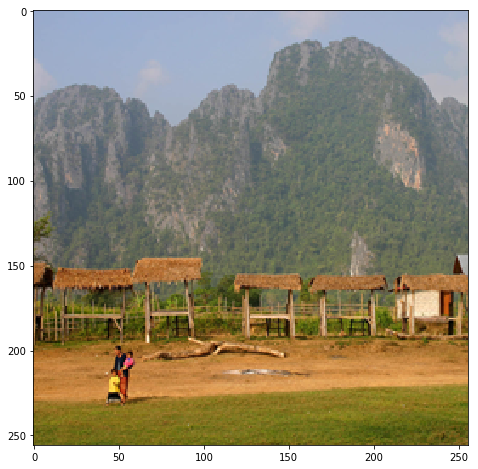

In [6]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = resizedImage.size
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(image)#這行可以註解掉，如果讀取都沒問題的話，因為顯示圖片很花時間


# 分配記憶體來處理pl上的資料
shape=(height, width, 3)三圍陣列指定常跟寬，3代表RGB三通道
np.uint8是因為每個元素值為0~255之間
cacheable=1代表陣列可存放cache，一定要設1

In [7]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(height, width, 3), dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(height, width, 3), dtype=np.uint8, cacheable=1)

In [8]:
in_buffer[:] = np.array(resizedImage)

In [9]:
def run_kernel():
    if user_input.lower() == "s":
        squareDma.sendchannel.transfer(in_buffer)
        squareDma.recvchannel.transfer(out_buffer)    
        squareCtrl.write(0x0,0x81)
        squareDma.sendchannel.wait()
        squareDma.recvchannel.wait()
    elif user_input.lower() == "r":
        rectangleDma.sendchannel.transfer(in_buffer)
        rectangleDma.recvchannel.transfer(out_buffer)    
        rectangleCtrl.write(0x0,0x81)
        rectangleDma.sendchannel.wait()
        rectangleDma.recvchannel.wait()

We will also need to do some setup with the MMIO interface 
With this IP, we will need to define both High and Low Hysteris Thresholds  

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x10            | Hysteresis Low                         |
| 0x18            | Hysteresis High                        |

In [10]:
run_kernel()

## 下面三個cell可重複執行，選好兩個threshold之後再離開

In [11]:
if user_input.lower() == "s":
    print(squareCtrl.read(0x10))
elif user_input.lower() == "r":
    print(rectangleCtrl.read(0x10))

80


In [12]:
if user_input.lower() == "s":
    print(squareCtrl.read(0x18))
elif user_input.lower() == "r":
    print(rectangleCtrl.read(0x18))

10


In [13]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

## Display detected edges

Image size: 512x512 pixels.


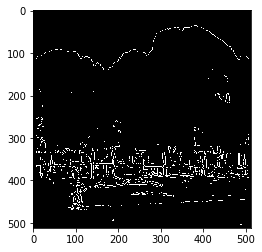

In [14]:
processed_image = Image.fromarray(out_buffer)
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(processed_image)
processed_image.save("images/80_10_outmountain256.png")

We can time the resize in PL operation.
Finally we need to reset all the contiguous memory buffers.

In [15]:
xlnk.xlnk_reset()